In [1]:
from typing import List, Tuple, Dict, Any, Optional
from pandarallel import pandarallel
import os
import re
import sys
import json
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
from tqdm.auto import tqdm
tqdm.pandas()
pandarallel.initialize(progress_bar=True)

INFO: Pandarallel will run on 24 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [2]:
import sys
BASE_PATH = ".."
sys.path.append(BASE_PATH)

# GENERATION_PATH_LLM_API = Path(
#     BASE_PATH, "program_bank/v016/2025_01_13__11_30__qiskit")
GENERATION_PATH_LLM_API = Path(
    BASE_PATH, "program_bank/v016/2025_01_13__11_47__qiskit")

### Task description: Run Qiskit Scripts

**Objective:**
Develop a Python script to scan and run Qiskit scripts ending in `circuit.py` from a specified directory using two different versions of Qiskit Docker images. The script should log the results and errors for each version, generate a summary report, and visualize the error analysis.

**Requirements:**
1. **Directory Scanning:**
   - Scan the directory specified by the global variable `GENERATION_PATH_LLM_API` for all Python files ending with `circuit.py`.

2. **Running Qiskit Scripts:**
   - For each identified script, run it using two versions of Qiskit Docker images:
     - Version 1: `qiskit_image_1.2.0`
     - Version 2: `qiskit_image_0.45.0`
   - Use the `run_qiskit_code_in_docker` function from `aiexchange.tools.docker_tools` to execute the scripts.
   - Use `tqdm` to display progress information during script execution.

3. **Logging Results:**
   - Log the output and errors for each script run with both versions.
   - Store the logs in the same directory as the script with the following naming convention:
     - For version 1.2.0: `<program_name_without_py>_120.log`
     - For version 0.45.0: `<program_name_without_py>_045.log`

4. **Success Criteria:**
   - A script run is considered successful if `"traceback" not in logs.lower()` and `"SyntaxError" not in logs`.

5. **Summary Report:**
   - Generate a summary report indicating how many scripts successfully ran with both versions.
   - Store the summary report in the specified directory.
   - Create a routine at the end of the script to read all the logs into a Pandas DataFrame with the following columns:
     - `program_name`
     - `log_045`
     - `log_120`
     - `error_045` (contains either "syntax" or "runtime")
     - `error_120` (contains either "syntax" or "runtime")
     - `success_045` (boolean)
     - `success_120` (boolean)

6. **Error Analysis and Visualization:**
   - Count the number of syntax errors and other traceback errors for each version.
   - Plot a stacked histogram showing the number of syntax errors and other traceback errors for each version.


In [7]:
from aiexchange.tools.docker_tools import run_qiskit_code_in_docker

# Directory scanning


def scan_directory_for_scripts(directory: str) -> List[str]:
    return [str(path) for path in Path(directory).rglob('*circuit.py')]

# Running Qiskit scripts


def extract_version(image_name: str) -> str:
    ver_w_dots = re.search(
        r'qiskit_image_(\d+\.\d+\.\d+)', image_name).group(1)
    return ver_w_dots.replace('.', '')


def run_scripts(
        scripts_paths: List[Path],
        qiskit_image_name: str) -> Tuple[str]:
    logs = []
    for script_path in tqdm(
            scripts_paths, desc=f"Running scripts with Qiskit {qiskit_image_name}"):
        script_content = Path(script_path).read_text()
        # check if result was already computed
        ver_suffix = extract_version(qiskit_image_name)
        log_result = f"{Path(script_path).stem}_{ver_suffix}.log"
        if Path(script_path).parent / log_result in Path(script_path).parent.glob(
                f"*_{ver_suffix}.log"):
            with open(Path(script_path).parent / log_result, 'r') as f:
                log = f.read()
        else:
            log = run_qiskit_code_in_docker(script_content, qiskit_image_name)
            with open(Path(script_path).parent / log_result, 'w') as f:
                f.write(log)
        logs.append(log)
    return logs
# Summary report


def generate_summary_report(
        logs_045: Tuple[str],
        logs_120: Tuple[str]) -> pd.DataFrame:
    data = []
    for log_045, log_120 in zip(logs_045, logs_120):
        data.append(
            {'log_045': log_045, 'log_120': log_120})
    return pd.DataFrame(data)


# Main execution
scripts_paths = scan_directory_for_scripts(GENERATION_PATH_LLM_API)
print(f"Found {len(scripts_paths)} scripts to run")

logs_045 = run_scripts(scripts_paths, qiskit_image_name='qiskit_image_0.45.0')
logs_120 = run_scripts(scripts_paths, qiskit_image_name='qiskit_image_1.2.0')

Found 100 scripts to run


Running scripts with Qiskit qiskit_image_0.45.0:   0%|          | 0/100 [00:00<?, ?it/s]

Running scripts with Qiskit qiskit_image_1.2.0:   0%|          | 0/100 [00:00<?, ?it/s]

In [8]:

summary_df = generate_summary_report(logs_045, logs_120)
summary_df["program_name"] = [Path(script).stem for script in scripts_paths]
summary_df = summary_df.sort_values(by="program_name")

summary_df["metadata"] = summary_df["program_name"].apply(
    lambda name: json.dumps(
        json.load(
            open(
                Path(
                    GENERATION_PATH_LLM_API,
                    f"{name.replace('circuit', 'metadata')}.json"))),
        indent=4))


def extract_error_type(log: str) -> str:
    match = re.search(r'(\w+Error)', log)
    if match:
        return match.group(1)
    return 'Correct'


summary_df['error_type_045'] = summary_df['log_045'].apply(extract_error_type)
summary_df['error_type_120'] = summary_df['log_120'].apply(extract_error_type)


def get_error_throwing_line(log: str) -> Optional[int]:
    match = re.search(r'File "/workspace/code_sample.py", line (\d+)', log)
    if match:
        return int(match.group(1))
    return None


summary_df['last_executed_row_045'] = summary_df['log_045'].apply(
    get_error_throwing_line).astype('Int64')
summary_df['last_executed_row_120'] = summary_df['log_120'].apply(
    get_error_throwing_line).astype('Int64')


def is_successful(log: str) -> bool:
    return "traceback" not in log.lower() and "SyntaxError" not in log and not "IndentationError" in log


summary_df["success_045"] = summary_df["log_045"].apply(is_successful)
summary_df["success_120"] = summary_df["log_120"].apply(is_successful)


summary_df.to_csv(
    Path(GENERATION_PATH_LLM_API) / 'summary_report.csv', index=False)

In [9]:
summary_df

,log_045,log_120,program_name,metadata,error_type_045,error_type_120,last_executed_row_045,last_executed_row_120,success_045,success_120
19,"Traceback (most recent call last):\n File ""/w...",/workspace/code_sample.py:7: DeprecationWarnin...,0000001_07bf22_circuit,"{\n ""api_info"": {\n ""api_name"": ""__e...",TypeError,TypeError,7,7,False,False
28,"Traceback (most recent call last):\n File ""/w...","Traceback (most recent call last):\n File ""/w...",0000002_b025f1_circuit,"{\n ""api_info"": {\n ""api_name"": ""_bu...",TypeError,TypeError,24,24,False,False
15,"Traceback (most recent call last):\n File ""/w...","Traceback (most recent call last):\n File ""/w...",0000003_58aebb_circuit,"{\n ""api_info"": {\n ""api_name"": ""_er...",ModuleNotFoundError,ModuleNotFoundError,2,2,False,False
50,"Traceback (most recent call last):\n File ""/w...","Traceback (most recent call last):\n File ""/w...",0000004_6f983a_circuit,"{\n ""api_info"": {\n ""api_name"": ""dec...",ModuleNotFoundError,ModuleNotFoundError,2,2,False,False
83,[0.5]\n,[0.5]\n,0000005_07a495_circuit,"{\n ""api_info"": {\n ""api_name"": ""_ge...",Correct,Correct,<NA>,<NA>,True,True
...,...,...,...,...,...,...,...,...,...,...
6,"Traceback (most recent call last):\n File ""/w...","Traceback (most recent call last):\n File ""/w...",0000096_80dec1_circuit,"{\n ""api_info"": {\n ""api_name"": ""exp...",TypeError,TypeError,19,19,False,False
56,[]\n,[]\n,0000097_31010c_circuit,"{\n ""api_info"": {\n ""api_name"": ""com...",Correct,Correct,<NA>,<NA>,True,True
67,1.0\n,"Traceback (most recent call last):\n File ""/w...",0000098_51b298_circuit,"{\n ""api_info"": {\n ""api_name"": ""ave...",Correct,ImportError,<NA>,1,True,False
24,"Traceback (most recent call last):\n File ""/w...",,0000099_ccc7cc_circuit,"{\n ""api_info"": {\n ""api_name"": ""__a...",TypeError,Correct,9,<NA>,False,True


Percentage of corrects for Qiskit 0.45.0: 24.00%
Percentage of corrects for Qiskit 1.2.0: 25.00%


<Figure size 1400x700 with 0 Axes>

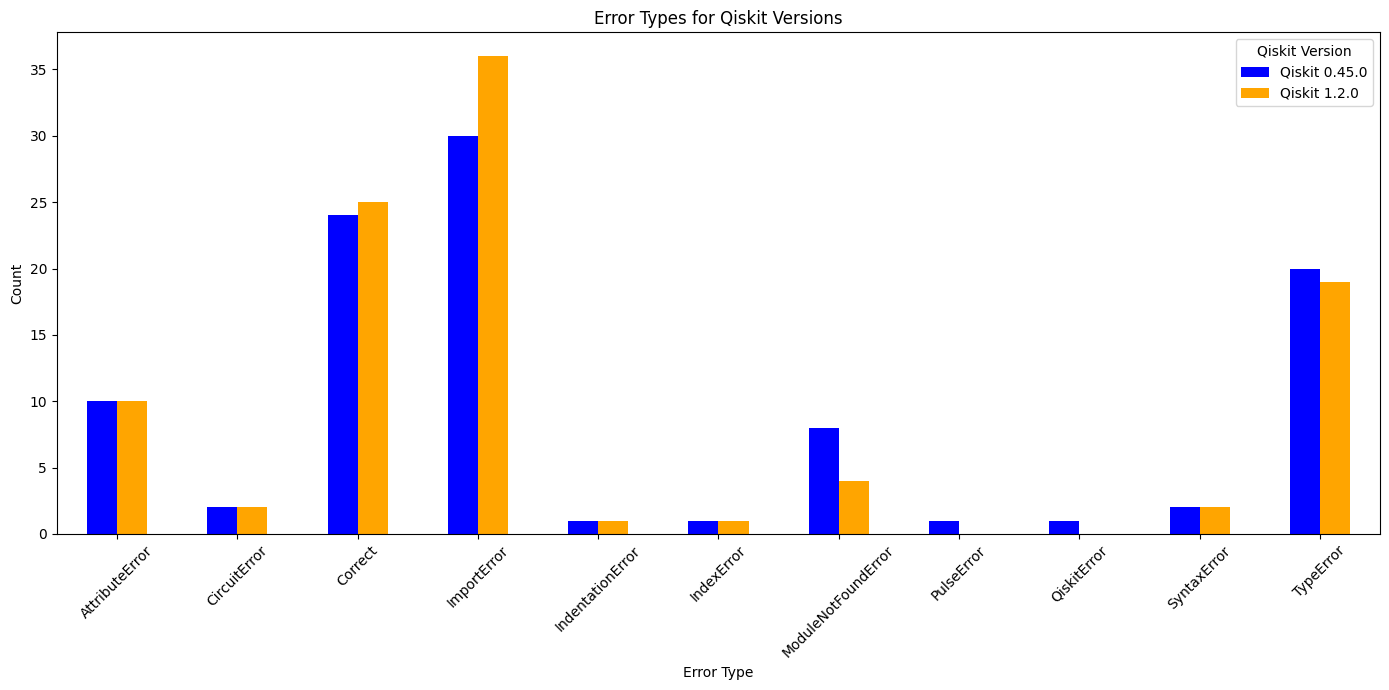

In [10]:
import re
import seaborn as sns


summary_df
# Plotting the error type counts for each version
plt.figure(figsize=(14, 7))

# Get unique error types
unique_error_types_045 = summary_df['error_type_045'].unique()
unique_error_types_120 = summary_df['error_type_120'].unique()

# Create palette
palette_045 = {
    error_type: 'green'
    if error_type == 'Correct' else 'red'
    for error_type in unique_error_types_045}
palette_120 = {
    error_type: 'green'
    if error_type == 'Correct' else 'red'
    for error_type in unique_error_types_120}

# Plotting the error type counts for each version side by side
error_counts_045 = summary_df['error_type_045'].value_counts()
error_counts_120 = summary_df['error_type_120'].value_counts()

# Create a DataFrame for plotting
error_counts_df = pd.DataFrame({
    'Qiskit 0.45.0': error_counts_045,
    'Qiskit 1.2.0': error_counts_120
}).fillna(0)

error_counts_df.plot(kind='bar', figsize=(14, 7), color=['blue', 'orange'])
plt.title('Error Types for Qiskit Versions')
plt.xlabel('Error Type')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend(title='Qiskit Version')

correct_045 = summary_df['error_type_045'].value_counts().get('Correct', 0)
correct_120 = summary_df['error_type_120'].value_counts().get('Correct', 0)

total_045 = len(summary_df)
total_120 = len(summary_df)

percentage_correct_045 = (correct_045 / total_045) * 100
percentage_correct_120 = (correct_120 / total_120) * 100

print(
    f"Percentage of corrects for Qiskit 0.45.0: {percentage_correct_045:.2f}%")
print(
    f"Percentage of corrects for Qiskit 1.2.0: {percentage_correct_120:.2f}%")

plt.tight_layout()
plt.show()

In [13]:
from IPython.display import display, Markdown

max_to_show = 2


def pretty_print_summary(df: pd.DataFrame, max_to_show: int = 5):
    for index, row in df.head(max_to_show).iterrows():
        program_name = row['program_name']
        log_045 = row['log_045']
        log_120 = row['log_120']
        success_045 = row['success_045']
        success_120 = row['success_120']

        program_path = os.path.join(
            GENERATION_PATH_LLM_API, f"{program_name}.py")
        program_code = Path(program_path).read_text()
        display(Markdown(f"# {program_name}"))
        display(Markdown(f"## Code"))
        display(Markdown(f"```python\n{program_code}\n```"))
        display(Markdown(f"## Logs"))
        display(Markdown(f"### Qiskit 0.45.0"))
        display(Markdown(f"```\n{log_045}```"))
        display(Markdown(f"### Qiskit 1.2.0"))
        display(Markdown(f"```\n{log_120}```"))
        display(Markdown(f"## Metadata"))
        display(Markdown(f"```json\n{row['metadata']}\n```"))


df = summary_df[summary_df['error_type_045'] == 'Correct']
# df = summary_df[summary_df['error_type_120'] == 'Correct']
# df = summary_df[summary_df['error_type_045'] == 'ImportError']

pretty_print_summary(df, max_to_show)

# 0000005_07a495_circuit

## Code

```python
from qiskit import QuantumCircuit
from qiskit.pulse.library.symbolic_pulses import _get_expression_args
import numpy as np
from sympy import symbols, sin, pi

x = symbols('x')
expr = sin(2 * pi * x)
params = {'x': 0.5}

qc = QuantumCircuit(1)
qc.h(0)

args = _get_expression_args(expr, params)
print(args)
```

## Logs

### Qiskit 0.45.0

```
[0.5]
```

### Qiskit 1.2.0

```
[0.5]
```

## Metadata

```json
{
    "api_info": {
        "api_name": "_get_expression_args",
        "full_api_name": "_get_expression_args",
        "api_description": "A helper function to get argument to evaluate expression.\n\nArgs:\n    expr: Symbolic expression to evaluate.\n    params: Dictionary of parameter, which is a superset of expression arguments.\n\nReturns:\n    Arguments passed to the lambdified expression.\n\nRaises:\n    PulseError: When a free symbol value is not defined in the pulse instance parameters.",
        "api_signature": "_get_expression_args(expr, params)",
        "file_path": "/usr/local/lib/python3.10/site-packages/qiskit/pulse/library/symbolic_pulses.py"
    },
    "dspy_store": {
        "reasoning": "The provided API is a helper function named _get_expression_args which is used to get the arguments to evaluate an expression. This function takes in a symbolic expression and a dictionary of parameters. It returns the arguments passed to the lambdified expression and raises a PulseError if a free symbol value is not defined in the pulse instance parameters. To generate a program inspired by this API, we can create a simple quantum circuit and use the _get_expression_args function to evaluate an expression. We will import the necessary Qiskit modules, create a quantum circuit, define a symbolic expression, and then use the _get_expression_args function to get the arguments.",
        "generated_python_program": "from qiskit import QuantumCircuit\nfrom qiskit.pulse.library.symbolic_pulses import _get_expression_args\nimport numpy as np\nfrom sympy import symbols, sin, pi\n\nx = symbols('x')\nexpr = sin(2 * pi * x)\nparams = {'x': 0.5}\n\nqc = QuantumCircuit(1)\nqc.h(0)\n\nargs = _get_expression_args(expr, params)\nprint(args)",
        "variable_name_of_circuit": "qc"
    }
}
```

# 0000014_625530_circuit

## Code

```python
from qiskit import QuantumCircuit
from qiskit.qasm2.parse import _generate_delay

qc = QuantumCircuit(2)
qc.h(0)
qc.cx(0, 1)
print(_generate_delay(1))
qc.barrier()
qc.x(0)
qc.barrier()
```

## Logs

### Qiskit 0.45.0

```
Delay(duration=1[unit=dt])
```

### Qiskit 1.2.0

```
Delay(duration=1[unit=dt])
```

## Metadata

```json
{
    "api_info": {
        "api_name": "_generate_delay",
        "full_api_name": "_generate_delay",
        "api_description": "",
        "api_signature": "_generate_delay(time)",
        "file_path": "/usr/local/lib/python3.10/site-packages/qiskit/qasm2/parse.py"
    },
    "dspy_store": {
        "reasoning": "The given API is _generate_delay, which is used to generate a delay in a quantum circuit. This function is typically used to insert idle time in a circuit. To generate a program inspired by this API, we will create a quantum circuit, apply some gates, and then use the _generate_delay function to insert a delay.",
        "generated_python_program": "from qiskit import QuantumCircuit\nfrom qiskit.qasm2.parse import _generate_delay\n\nqc = QuantumCircuit(2)\nqc.h(0)\nqc.cx(0, 1)\nprint(_generate_delay(1))\nqc.barrier()\nqc.x(0)\nqc.barrier()",
        "variable_name_of_circuit": "qc"
    }
}
```

In [17]:
import difflib


def are_different_in_memory_address(log1: str, log2: str) -> bool:
    # different only in the memory address of the object
    diff = difflib.ndiff(log1.splitlines(), log2.splitlines())
    for line in diff:
        if re.search(r'object at 0x[0-9a-f]+>', line):
            return True
    return False


def last_line(log: str) -> str:
    return log.splitlines()[-1] if log.splitlines() else ''


def are_logs_meaningfully_different(log1: str, log2: str) -> bool:
    if last_line(log1) != last_line(log2):
        if are_different_in_memory_address(last_line(log1), last_line(log2)):
            return False
        return True
    return False


df_same_error_type_diff_logs = summary_df[
    (summary_df['error_type_045'] == summary_df['error_type_120']) &
    # (summary_df['log_045'].apply(last_line) != summary_df['log_120'].apply(last_line))
    summary_df.apply(lambda row: are_logs_meaningfully_different(
        row['log_045'], row['log_120']), axis=1)
]

# n_data = len(df_same_error_type_diff_logs)
# display(Markdown(
#     f"# Same error but different logs ({n_data} programs)"))
# pretty_print_summary(df_same_error_type_diff_logs, max_to_show=n_data)

df_different_logs = summary_df[
    summary_df.apply(lambda row: are_logs_meaningfully_different(
        row['log_045'], row['log_120']), axis=1)
]

n_data = len(df_different_logs)
display(Markdown(f"# Different logs ({n_data} programs)"))
# pretty_print_summary(df_different_logs, max_to_show=n_data)


def determine_executed_more_lines(row):
    row_045 = row["last_executed_row_045"]
    row_120 = row["last_executed_row_120"]

    if pd.isna(row_045) and pd.isna(row_120):
        return "same"

    row_045 = int(row_045) if not pd.isna(row_045) else None
    row_120 = int(row_120) if not pd.isna(row_120) else None

    if row_045 is None:
        return "qiskit_120"
    if row_120 is None:
        return "qiskit_045"

    if row_120 > row_045:
        return "qiskit_120"
    elif row_120 < row_045:
        return "qiskit_045"
    else:
        return "same"


df_same_error_type_diff_logs = df_same_error_type_diff_logs.copy()
df_same_error_type_diff_logs["executed_more_lines"] = df_same_error_type_diff_logs.apply(
    determine_executed_more_lines, axis=1)
df_same_error_type_diff_logs["executed_more_lines"].value_counts()
pretty_print_summary(df_same_error_type_diff_logs, max_to_show=5)

# Different logs (22 programs)

# 0000015_7851ae_circuit

## Code

```python
from qiskit import QuantumCircuit, execute
from qiskit.qobj import Qobj
from qiskit.qobj import pulse_instruction
from qiskit.pulse import ShiftFrequency

class InstructionToQobjConverter:
    def _convert_shift_frequency(self, instruction, time_offset):
        # This is a placeholder for the actual implementation
        pass

def main():
    converter = InstructionToQobjConverter()
    circuit = QuantumCircuit(1)
    circuit.x(0)
    instruction = ShiftFrequency(0.1, 0)
    time_offset = 0.0
    qobj_instruction = converter._convert_shift_frequency(instruction, time_offset)
    # Create a Qobj
    qobj = Qobj(instructions=[qobj_instruction])
    print(qobj)

if __name__ == "__main__":
    main()
```

## Logs

### Qiskit 0.45.0

```
Traceback (most recent call last):
  File "/workspace/code_sample.py", line 2, in <module>
    from qiskit.qobj import Qobj
ImportError: cannot import name 'Qobj' from 'qiskit.qobj' (/usr/local/lib/python3.10/site-packages/qiskit/qobj/__init__.py)
```

### Qiskit 1.2.0

```
Traceback (most recent call last):
  File "/workspace/code_sample.py", line 1, in <module>
    from qiskit import QuantumCircuit, execute
ImportError: cannot import name 'execute' from 'qiskit' (/usr/local/lib/python3.10/site-packages/qiskit/__init__.py)
```

## Metadata

```json
{
    "api_info": {
        "api_name": "_convert_shift_frequency",
        "full_api_name": "InstructionToQobjConverter._convert_shift_frequency",
        "api_description": "Return converted `ShiftFrequency`.\n\nArgs:\n    instruction: Qiskit Pulse shift frequency instruction.\n    time_offset: Offset time.\n\nReturns:\n    Qobj instruction data.",
        "api_signature": "_convert_shift_frequency(self, instruction, time_offset)",
        "file_path": "/usr/local/lib/python3.10/site-packages/qiskit/qobj/converters/pulse_instruction.py"
    },
    "dspy_store": {
        "reasoning": "To generate a Python program inspired by the given Qiskit API, we need to import the necessary modules and use the provided API to create a QuantumCircuit object. The InstructionToQobjConverter._convert_shift_frequency function is used to convert a shift frequency instruction to a Qobj instruction data. We will create a class that utilizes this function to demonstrate its usage.",
        "generated_python_program": "from qiskit import QuantumCircuit, execute\nfrom qiskit.qobj import Qobj\nfrom qiskit.qobj import pulse_instruction\nfrom qiskit.pulse import ShiftFrequency\n\nclass InstructionToQobjConverter:\n    def _convert_shift_frequency(self, instruction, time_offset):\n        # This is a placeholder for the actual implementation\n        pass\n\ndef main():\n    converter = InstructionToQobjConverter()\n    circuit = QuantumCircuit(1)\n    circuit.x(0)\n    instruction = ShiftFrequency(0.1, 0)\n    time_offset = 0.0\n    qobj_instruction = converter._convert_shift_frequency(instruction, time_offset)\n    # Create a Qobj\n    qobj = Qobj(instructions=[qobj_instruction])\n    print(qobj)\n\nif __name__ == \"__main__\":\n    main()",
        "variable_name_of_circuit": "circuit"
    }
}
```

# 0000020_1e4000_circuit

## Code

```python
from qiskit import QuantumCircuit
from qiskit.circuit.library import XGate

qc = QuantumCircuit(2)
qc.h(0)
qc.cx(0, 1)
gate = qc.to_gate()
print(gate)
```

## Logs

### Qiskit 0.45.0

```
Instruction(name='circuit-152', num_qubits=2, num_clbits=0, params=[])
```

### Qiskit 1.2.0

```
Instruction(name='circuit-160', num_qubits=2, num_clbits=0, params=[])
```

## Metadata

```json
{
    "api_info": {
        "api_name": "to_gate",
        "full_api_name": "QuantumCircuit.to_gate",
        "api_description": "Create a :class:`.Gate` out of this circuit.  The circuit must act only qubits and\ncontain only unitary operations.\n\n.. seealso::\n    :func:`circuit_to_gate`\n        The underlying driver of this method.\n\nArgs:\n    parameter_map: For parameterized circuits, a mapping from parameters in the circuit to\n        parameters to be used in the gate. If ``None``, existing circuit parameters will\n        also parameterize the gate.\n    label : Optional gate label.\n\nReturns:\n    Gate: a composite gate encapsulating this circuit (can be decomposed back).",
        "api_signature": "to_gate(self, parameter_map, label)",
        "file_path": "/usr/local/lib/python3.10/site-packages/qiskit/circuit/quantumcircuit.py"
    },
    "dspy_store": {
        "reasoning": "The provided API is a method of the QuantumCircuit class in Qiskit, which converts a QuantumCircuit into a Gate object. To generate a program inspired by this API, we need to create a QuantumCircuit object, apply some unitary operations to it, and then use the to_gate method to convert it into a Gate object.",
        "generated_python_program": "from qiskit import QuantumCircuit\nfrom qiskit.circuit.library import XGate\n\nqc = QuantumCircuit(2)\nqc.h(0)\nqc.cx(0, 1)\ngate = qc.to_gate()\nprint(gate)",
        "variable_name_of_circuit": "qc"
    }
}
```

# 0000021_adbb42_circuit

## Code

```python
from qiskit import QuantumCircuit
from qiskit.circuit import QuantumCircuit as QC

def test_cast():
    circuit = QuantumCircuit(2, name='test_circuit')
    circuit.h(0)
    circuit.cx(0, 1)

    # Attempt to cast an integer to a float
    int_value = 10
    float_value = QC.cast(int_value, float)
    print(f"Casting {int_value} to float: {float_value}")

    # Attempt to cast a string to an integer
    str_value = "20"
    int_cast_value = QC.cast(str_value, int)
    print(f"Casting '{str_value}' to int: {int_cast_value}")

    # Attempt to cast a list to a string (which should fail and return the list)
    list_value = [1, 2, 3]
    str_list_value = QC.cast(list_value, str)
    print(f"Casting {list_value} to str: {str_list_value}")

test_cast()
```

## Logs

### Qiskit 0.45.0

```
Casting 10 to float: 10.0
Casting '20' to int: 20
Casting [1, 2, 3] to str: [1, 2, 3]
```

### Qiskit 1.2.0

```
/workspace/code_sample.py:11: DeprecationWarning: The method ``qiskit.circuit.quantumcircuit.QuantumCircuit.cast()`` is deprecated as of qiskit 1.2. It will be removed in the 2.0 release. This method is only used as an internal helper and will be removed with no replacement.
  float_value = QC.cast(int_value, float)
Casting 10 to float: 10.0
Casting '20' to int: 20
Casting [1, 2, 3] to str: [1, 2, 3]
/workspace/code_sample.py:16: DeprecationWarning: The method ``qiskit.circuit.quantumcircuit.QuantumCircuit.cast()`` is deprecated as of qiskit 1.2. It will be removed in the 2.0 release. This method is only used as an internal helper and will be removed with no replacement.
  int_cast_value = QC.cast(str_value, int)
/workspace/code_sample.py:21: DeprecationWarning: The method ``qiskit.circuit.quantumcircuit.QuantumCircuit.cast()`` is deprecated as of qiskit 1.2. It will be removed in the 2.0 release. This method is only used as an internal helper and will be removed with no replacement.
  str_list_value = QC.cast(list_value, str)
```

## Metadata

```json
{
    "api_info": {
        "api_name": "cast",
        "full_api_name": "QuantumCircuit.cast",
        "api_description": "Best effort to cast value to type. Otherwise, returns the value.",
        "api_signature": "cast(value, type_)",
        "file_path": "/usr/local/lib/python3.10/site-packages/qiskit/circuit/quantumcircuit.py"
    },
    "dspy_store": {
        "reasoning": "To generate a program inspired by the QuantumCircuit.cast API, we need to understand its purpose, which is to attempt to cast a given value to a specified type. If the casting is successful, it returns the casted value; otherwise, it returns the original value. Our generated program will utilize this API to demonstrate its functionality by casting different types of values to various types and observing the outcomes. We will create a QuantumCircuit, apply some operations to it, and then use the cast method to attempt type conversions on different values.",
        "generated_python_program": "from qiskit import QuantumCircuit\nfrom qiskit.circuit import QuantumCircuit as QC\n\ndef test_cast():\n    circuit = QuantumCircuit(2, name='test_circuit')\n    circuit.h(0)\n    circuit.cx(0, 1)\n\n    # Attempt to cast an integer to a float\n    int_value = 10\n    float_value = QC.cast(int_value, float)\n    print(f\"Casting {int_value} to float: {float_value}\")\n\n    # Attempt to cast a string to an integer\n    str_value = \"20\"\n    int_cast_value = QC.cast(str_value, int)\n    print(f\"Casting '{str_value}' to int: {int_cast_value}\")\n\n    # Attempt to cast a list to a string (which should fail and return the list)\n    list_value = [1, 2, 3]\n    str_list_value = QC.cast(list_value, str)\n    print(f\"Casting {list_value} to str: {str_list_value}\")\n\ntest_cast()",
        "variable_name_of_circuit": "circuit"
    }
}
```

# 0000044_c382a4_circuit

## Code

```python
from qiskit import QuantumCircuit, execute, Aer
from qiskit.providers.fake_provider import GenericBackendV2

backend = GenericBackendV2()
target_properties = backend.target()
circuit = QuantumCircuit(2, 2)
circuit.h(0)
circuit.cx(0, 1)
circuit.measure([0, 1], [0, 1])
```

## Logs

### Qiskit 0.45.0

```
Traceback (most recent call last):
  File "/workspace/code_sample.py", line 2, in <module>
    from qiskit.providers.fake_provider import GenericBackendV2
ImportError: cannot import name 'GenericBackendV2' from 'qiskit.providers.fake_provider' (/usr/local/lib/python3.10/site-packages/qiskit/providers/fake_provider/__init__.py)
```

### Qiskit 1.2.0

```
Traceback (most recent call last):
  File "/workspace/code_sample.py", line 1, in <module>
    from qiskit import QuantumCircuit, execute, Aer
ImportError: cannot import name 'execute' from 'qiskit' (/usr/local/lib/python3.10/site-packages/qiskit/__init__.py)
```

## Metadata

```json
{
    "api_info": {
        "api_name": "target",
        "full_api_name": "GenericBackendV2.target",
        "api_description": "",
        "api_signature": "target(self)",
        "file_path": "/usr/local/lib/python3.10/site-packages/qiskit/providers/fake_provider/generic_backend_v2.py"
    },
    "dspy_store": {
        "reasoning": "The GenericBackendV2.target API is used to get the target properties of a backend. To generate a program inspired by this API, we can create a QuantumCircuit object and use the target API to get the target properties of a backend.",
        "generated_python_program": "from qiskit import QuantumCircuit, execute, Aer\nfrom qiskit.providers.fake_provider import GenericBackendV2\n\nbackend = GenericBackendV2()\ntarget_properties = backend.target()\ncircuit = QuantumCircuit(2, 2)\ncircuit.h(0)\ncircuit.cx(0, 1)\ncircuit.measure([0, 1], [0, 1])",
        "variable_name_of_circuit": "circuit"
    }
}
```

# 0000051_41c93d_circuit

## Code

```python
from qiskit import QuantumCircuit, transpile
from qiskit.transpiler.preset_passmanagers.generate_preset_pass_manager import _parse_dt
from qiskit.providers.aer import AerSimulator

def main():
    # Create a QuantumCircuit
    circuit = QuantumCircuit(2)
    circuit.h(0)
    circuit.cx(0, 1)

    # Initialize a backend
    backend = AerSimulator()

    # Use the _parse_dt function
    dt = _parse_dt('auto', backend)

    # Compile the circuit with the calculated dt
    compiled_circuit = transpile(circuit, backend, scheduling_method='asap', dt=dt)

    print(compiled_circuit)

main()
```

## Logs

### Qiskit 0.45.0

```
Traceback (most recent call last):
  File "/workspace/code_sample.py", line 2, in <module>
    from qiskit.transpiler.preset_passmanagers.generate_preset_pass_manager import _parse_dt
ModuleNotFoundError: No module named 'qiskit.transpiler.preset_passmanagers.generate_preset_pass_manager'
```

### Qiskit 1.2.0

```
Traceback (most recent call last):
  File "/workspace/code_sample.py", line 3, in <module>
    from qiskit.providers.aer import AerSimulator
ModuleNotFoundError: No module named 'qiskit.providers.aer'
```

## Metadata

```json
{
    "api_info": {
        "api_name": "_parse_dt",
        "full_api_name": "_parse_dt",
        "api_description": "",
        "api_signature": "_parse_dt(dt, backend)",
        "file_path": "/usr/local/lib/python3.10/site-packages/qiskit/transpiler/preset_passmanagers/generate_preset_pass_manager.py"
    },
    "dspy_store": {
        "reasoning": "The _parse_dt function from the generate_preset_pass_manager module in Qiskit's transpiler is used to parse the dt (dilation time) argument for a given backend. To create a program inspired by this API, we will use it to calculate the dilation time for a QuantumCircuit and then use this circuit to demonstrate the functionality of the _parse_dt function.",
        "generated_python_program": "from qiskit import QuantumCircuit, transpile\nfrom qiskit.transpiler.preset_passmanagers.generate_preset_pass_manager import _parse_dt\nfrom qiskit.providers.aer import AerSimulator\n\ndef main():\n    # Create a QuantumCircuit\n    circuit = QuantumCircuit(2)\n    circuit.h(0)\n    circuit.cx(0, 1)\n\n    # Initialize a backend\n    backend = AerSimulator()\n\n    # Use the _parse_dt function\n    dt = _parse_dt('auto', backend)\n\n    # Compile the circuit with the calculated dt\n    compiled_circuit = transpile(circuit, backend, scheduling_method='asap', dt=dt)\n\n    print(compiled_circuit)\n\nmain()",
        "variable_name_of_circuit": "circuit"
    }
}
```